In [29]:
using HDF5
using PyPlot
using Statistics

In [9]:
U = h5open("v1_layer3/U_matrix", "r") do file
    read(file, "matrix")end

V = h5open("v1_layer3/V_matrix", "r") do file
    read(file, "matrix")end

M = h5open("v1_layer3/M_matrix", "r") do file
    read(file, "matrix")end

xgrid = h5open("v1_layer3/xgrid_matrix", "r") do file
        read(file, "matrix")end

ygrid = h5open("v1_layer3/ygrid_matrix", "r") do file
        read(file, "matrix")end

63×63×393 Array{Float32, 3}:
[:, :, 1] =
   16.0    16.0    16.0    16.0    16.0  …    16.0    16.0    16.0    16.0
   32.0    32.0    32.0    32.0    32.0       32.0    32.0    32.0    32.0
   48.0    48.0    48.0    48.0    48.0       48.0    48.0    48.0    48.0
   64.0    64.0    64.0    64.0    64.0       64.0    64.0    64.0    64.0
   80.0    80.0    80.0    80.0    80.0       80.0    80.0    80.0    80.0
   96.0    96.0    96.0    96.0    96.0  …    96.0    96.0    96.0    96.0
  112.0   112.0   112.0   112.0   112.0      112.0   112.0   112.0   112.0
  128.0   128.0   128.0   128.0   128.0      128.0   128.0   128.0   128.0
  144.0   144.0   144.0   144.0   144.0      144.0   144.0   144.0   144.0
  160.0   160.0   160.0   160.0   160.0      160.0   160.0   160.0   160.0
  176.0   176.0   176.0   176.0   176.0  …   176.0   176.0   176.0   176.0
  192.0   192.0   192.0   192.0   192.0      192.0   192.0   192.0   192.0
  208.0   208.0   208.0   208.0   208.0      208.0   208.0 

In [20]:
replace!(U, NaN => 0)
replace!(V, NaN => 0)

63×63×393 Array{Float32, 3}:
[:, :, 1] =
 0.0        0.0        0.0        …  0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0        …  0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0        …  0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 0.0        0.0        0.0           0.0      0.0     0.0       0.0
 ⋮                                ⋱           ⋮                
 0.0       

In [47]:
function PIVtrajectories_grid(U::Array{Float32, 3}, V::Array{Float32, 3}, T0::Int64, T1::Int64, numpoints::Int64; 
                                subregion=( 1:-1, 1:-1 ), step=(1,1), scale=(1,1))

    # Length of the each axis of the vector field. 
    dims  = ( length( 1:size(U,1) ), length( 1:size(U,2) ) ) 

    # The user can limit the simulation to a certain subregion of the vector field. 
    sampling_region = [ length( subregion[i] ) == 0 ? (2:step[i]:dims[i]-1) : Base.StepRange( subregion[i].start, step[i], subregion[i].stop ) for i in 1:2 ];
    scale = (typeof(scale)<:Number) ? (scale,scale) : scale
    
    print(sampling_region)

    numT = T1 - T0;
    TrajectoriesY = zeros( Float32, numT, prod( length.(sampling_region) ) )
    TrajectoriesX = zeros( Float32, numT, prod( length.(sampling_region) ) )

    pidx = 0; 
    for x in sampling_region[2], y in sampling_region[1]

        pidx += 1; 

        # Placing a new particle inside the vector-field. This is done by 
        # randomly picking a random position withing the vector-field. 
        starting_pos = (y,x); 

        # Recording the starting position in the first timepoints in the trajectory tables for point $pidx. 
        TrajectoriesY[ 1, pidx ] = Float32( starting_pos[1] )
        TrajectoriesX[ 1, pidx ] = Float32( starting_pos[2] )

        # Sampling the translation at the current ( starting ) position
        dY = Float32( scale[1] * U[ starting_pos..., T0 ] )
        dX = Float32( scale[2] * V[ starting_pos..., T0 ] )
        
        # moving forward in time, from T0 to T1
        for t in 2:numT

            # New_pos = previous position + translation (dU,dV,dW); 
            updated_pos = ( TrajectoriesY[t-1, pidx], TrajectoriesX[t-1, pidx] ) .+ ( dY, dX ); 

            # Recording the updated position in the trajectory tables
            TrajectoriesY[t,pidx] = updated_pos[1]
            TrajectoriesX[t,pidx] = updated_pos[2]

            # Obtaining the integer index of the updated position
            int_updated_pos = round.( Int64, updated_pos ); 

            # If the (integer) updated position is out of the coordinates of the vector field, stop
            if any( int_updated_pos .< 1 ) || any( int_updated_pos .> dims ) 
                TrajectoriesY[ t:end, pidx ] .= TrajectoriesY[ t-1, pidx ]
                TrajectoriesX[ t:end, pidx ] .= TrajectoriesX[ t-1, pidx ]
                break
            end

            # Sampling the translation at the (integer) updated position
            dY = Float32( scale[1] * U[ int_updated_pos..., T0+t-1 ] )
            dX = Float32( scale[2] * V[ int_updated_pos..., T0+t-1 ] )
        end
    end

    return TrajectoriesY, TrajectoriesX
end

PIVtrajectories_grid (generic function with 2 methods)

In [74]:
y, x = PIVtrajectories_grid(U, V, 1, 393, 5)

StepRange{Int64, Int64}[2:1:62, 2:1:62]

(Float32[2.0 3.0 … 61.0 62.0; 2.0 3.0 … 61.0 62.0; … ; 35.01096 45.431232 … 61.0 62.0; 35.620125 45.431232 … 61.0 62.0], Float32[2.0 2.0 … 62.0 62.0; 2.0 2.0 … 62.0 62.0; … ; 25.407091 45.345123 … 62.0 62.0; 25.177357 45.345123 … 62.0 62.0])

In [65]:
prod( length.(StepRange{Int64, Int64}[2:1:62, 2:1:62]) )

3721

In [75]:
y1 = y[:, 10]

392-element Vector{Float32}:
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
 11.0
  ⋮
 55.28027
 55.514534
 55.64675
 55.507137
 55.073017
 54.489933
 54.52678
 54.279755
 54.259583
 53.943382
 53.791084
 53.508667

In [76]:
x1 = x[:, 10]

392-element Vector{Float32}:
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  2.0
  ⋮
 21.198486
 21.093128
 21.740982
 22.108099
 22.191357
 21.985634
 22.46273
 22.46273
 22.430908
 22.379494
 22.655014
 22.946287

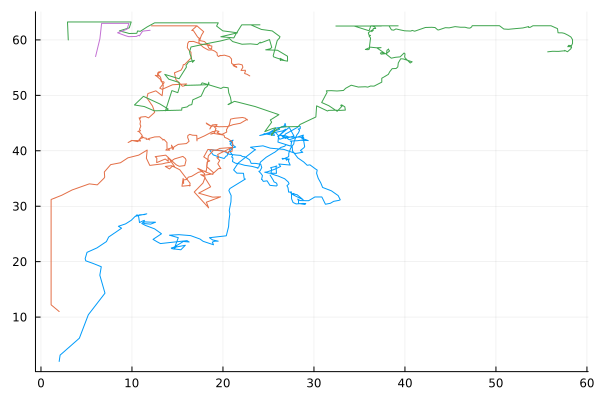

In [92]:
using Plots

Plots.plot(x[:,1], y[:,1], legend=false)
Plots.plot!(x[:,10], y[:,10])
Plots.plot!(x[:,120], y[:,120])
Plots.plot!(x[:,300], y[:,300])
#Plots.xlims!(1,1024)
#Plots.ylims!(1,1024)